In [38]:
import pandas as pd
import numpy as np
import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import matplotlib.ticker as ticker
# import k-means from clustering stage
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs 
from sklearn import preprocessing
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import folium # map rendering library
from folium.plugins import MarkerCluster
import folium.plugins as plugins
from IPython.display import Image 
from IPython.core.display import HTML
import itertools
print('Libraries imported.')

Libraries imported.


In [2]:
#Obtain Zipcodes (includes Latitude and Longitude)
zipcodes = pd.read_csv('zip_code_database.csv') #csv obtained from online zipcode site, includes all US zipcodes
print(zipcodes.shape)
zipcodes.head()

(42632, 15)


zip      type  decommissioned primary_city acceptable_cities  \
0  501    UNIQUE               0   Holtsville               NaN   
1  544    UNIQUE               0   Holtsville               NaN   
2  601  STANDARD               0     Adjuntas               NaN   
3  602  STANDARD               0       Aguada               NaN   
4  603  STANDARD               0    Aguadilla             Ramey   

                                 unacceptable_cities state  \
0                               I R S Service Center    NY   
1                                 Irs Service Center    NY   
2  Colinas Del Gigante, Jard De Adjuntas, Urb San...    PR   
3  Alts De Aguada, Bo Guaniquilla, Comunidad Las ...    PR   
4  Bda Caban, Bda Esteves, Bo Borinquen, Bo Ceiba...    PR   

                county             timezone area_codes world_region country  \
0       Suffolk County     America/New_York        631          NaN      US   
1       Suffolk County     America/New_York        631          NaN      US   
2   Adjuntas Municipio  America/Puerto_Rico    787,939          NaN      US   
3     Aguada Municipio  America/Puerto_Rico    787,939          NaN      US   
4  Aguadilla Municipio  America/Puerto_Rico        787          NaN      US   

   latitude  longitude  irs_estimated_population_2015  
0     40.81     -73.04                            562  
1     40.81     -73.04                              0  
2     18.16     -66.72                              0  
3     18.38     -67.18                              0  
4     18.43     -67.15                              0

In [3]:
#Initial data cleaning
#Remove unnecessary columns and check to make sure dropped
zipcodes.drop(['decommissioned','unacceptable_cities','timezone','world_region'],axis=1,inplace=True)
#Filter by 'Standard' type. This removes business or PO box specific zip codes
zipcodes = zipcodes[zipcodes['type']=='STANDARD']
print (zipcodes.shape)
zipcodes.head()

(29983, 11)


zip      type primary_city acceptable_cities state               county  \
2  601  STANDARD     Adjuntas               NaN    PR   Adjuntas Municipio   
3  602  STANDARD       Aguada               NaN    PR     Aguada Municipio   
4  603  STANDARD    Aguadilla             Ramey    PR  Aguadilla Municipio   
7  606  STANDARD      Maricao               NaN    PR    Maricao Municipio   
8  610  STANDARD       Anasco               NaN    PR     Anasco Municipio   

  area_codes country  latitude  longitude  irs_estimated_population_2015  
2    787,939      US     18.16     -66.72                              0  
3    787,939      US     18.38     -67.18                              0  
4        787      US     18.43     -67.15                              0  
7    787,939      US     18.18     -66.98                              0  
8        787      US     18.28     -67.14                              0

In [4]:
#When 'acceptable city' is NA, replace with primary_city
zipcodes['acceptable_cities'].fillna('0',inplace=True)
zipcodes.acceptable_cities.replace('0',zipcodes.primary_city,inplace=True)
zipcodes.head()

zip      type primary_city acceptable_cities state               county  \
2  601  STANDARD     Adjuntas          Adjuntas    PR   Adjuntas Municipio   
3  602  STANDARD       Aguada            Aguada    PR     Aguada Municipio   
4  603  STANDARD    Aguadilla             Ramey    PR  Aguadilla Municipio   
7  606  STANDARD      Maricao           Maricao    PR    Maricao Municipio   
8  610  STANDARD       Anasco            Anasco    PR     Anasco Municipio   

  area_codes country  latitude  longitude  irs_estimated_population_2015  
2    787,939      US     18.16     -66.72                              0  
3    787,939      US     18.38     -67.18                              0  
4        787      US     18.43     -67.15                              0  
7    787,939      US     18.18     -66.98                              0  
8        787      US     18.28     -67.14                              0

In [7]:
#Filtered for Tacoma area
tacomazip=zipcodes[zipcodes['zip'].between(98399,98500)]
print(tacomazip.shape)
print('There are {} unique city names in the Tacoma metro area'.format(len(tacomazip['acceptable_cities'].unique())))
#Filtered for Seattle area
seattlezip = zipcodes[zipcodes['zip'].between(98099,98200)]
print(seattlezip.shape)
print('There are {} unique city names in the Seattle metro area'.format(len(seattlezip['acceptable_cities'].unique())))

(26, 11)
There are 9 unique city names in the Tacoma metro area
(42, 11)
There are 12 unique city names in the Seattle metro area


In [10]:
#In order to easily distinguish different zipcode areas, add numbers to duplicate city names
taclist = tacomazip['acceptable_cities'].to_list()
sealist = seattlezip['acceptable_cities'].to_list()

Tcities = []
for i, v in enumerate (taclist):
    totalcount = taclist.count(v)
    count = taclist[:i].count(v)
    Tcities.append(v + str(count + 1) if totalcount > 1 else v)
    
Scities = []
for i, v in enumerate (sealist):
    totalcount = sealist.count(v)
    count = sealist[:i].count(v)
    Scities.append(v + str(count + 1) if totalcount > 1 else v)

In [ ]:
#Add created list back to initial dataframe
tacomazip['cityname']=Tcities
seattlezip['cityname']=Scities

In [15]:
#Check to make sure new column populated correctly, the shape & unique should be equal
print(tacomazip.shape)
print('There are {} unique city names in the Tacoma metro area'.format(len(tacomazip['cityname'].unique())))
print(seattlezip.shape)
print('There are {} unique city names in the Tacoma metro area'.format(len(seattlezip['cityname'].unique())))

(26, 12)
There are 26 unique city names in the Tacoma metro area
(42, 12)
There are 42 unique city names in the Tacoma metro area


In [16]:
#Obtain Lat/Long for Tacoma for use in Folium
address = 'Tacoma, WA'

geolocator = Nominatim (user_agent='tacoma_explorer')
location= geolocator.geocode(address)
latTac=location.latitude
longTac= location.longitude

print('The geographical location of Tacoma is {}, {}.'.format(latTac,longTac))

The geographical location of Tacoma is 47.2495798, -122.4398746.


In [17]:
#Obtain Lat/Long for Seattle
address = 'Seattle, WA'

geolocator = Nominatim (user_agent='seattle_explorer')
location= geolocator.geocode(address)
latSea=location.latitude
longSea= location.longitude

print('The geographical location of Seattle is {}, {}.'.format(latSea,longSea))

The geographical location of Seattle is 47.6038321, -122.3300624.


In [256]:
#Prep for Foursquare API use
CLIENT_ID = 'Client Id' # your Foursquare ID
CLIENT_SECRET = 'Client Secret' # your Foursquare Secret
VERSION = '20200301'
LIMIT = 100

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

#This categoryid will only return Foursquare results associated with food
categoryid = '4d4b7105d754a06374d81259'

Your credentails:
CLIENT_ID: Client Id
CLIENT_SECRET:Client Secret


In [19]:
#Function for Fourquare Search with 1610 meters/0.5 mile set as the radius
def getNearbyVenues(names,latitudes,longitudes,radius=1610):
    venues_list=[]
    for name,lat,long in zip(names,latitudes,longitudes):
        print(name)
    
        url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}&categoryId={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        lat, 
        long, 
        VERSION,
        radius, 
        LIMIT, categoryid)
        
        results = requests.get(url).json()['response']['groups'][0]['items']
        
        venues_list.append([(
            name,
            lat,
            long,
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [20]:
#First obtain venues for Tacoma area
tacoma_venues = getNearbyVenues(tacomazip['cityname'],tacomazip['latitude'],tacomazip['longitude'])

Tacoma1
Tacoma2
Tacoma3
Tacoma4
Tacoma5
Ruston
Tacoma6
Lakewood1
Tacoma7
Tacoma8
Tacoma9
Tacoma10
Fife
Fort Lewis, Ft Lewis, Joint Base Lewis Mcchord, Lewis Mcchord
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchord Afb, Tacoma1
Tacoma11
Tacoma12
Parkland1
Parkland2
Parkland3
Tacoma13
Fircrest, University Pl, University Place
Tacoma, University Pl
Lakewood2
Tacoma14
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchord Afb, Tacoma2


In [21]:
#See how many venues in Tacoma
print(tacoma_venues.shape)
tacoma_venues.head()

(625, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0      Tacoma1                  47.26                 -122.44   
1      Tacoma1                  47.26                 -122.44   
2      Tacoma1                  47.26                 -122.44   
3      Tacoma1                  47.26                 -122.44   
4      Tacoma1                  47.26                 -122.44   

                             Venue  Venue Latitude  Venue Longitude  \
0               Over the Moon Cafe       47.257328      -122.441662   
1                      The Matador       47.256636      -122.439188   
2                    Corina Bakery       47.258098      -122.444674   
3              Stink Cheese & Meat       47.257622      -122.442825   
4  McMenamins Elks Temple Main Pub       47.257967      -122.440578   

        Venue Category  
0  American Restaurant  
1   Mexican Restaurant  
2               Bakery  
3        Deli / Bodega  
4  American Restaurant

In [26]:
#Filter for just Venue Category of Restaurants
tacfood = tacoma_venues[tacoma_venues['Venue Category'].str.contains('Restaurant')]
#Remove the non-descriptive category 'Restaurant'
tacfood = tacfood[tacfood['Venue Category']!='Restaurant']
print(tacfood.shape)
print ('There are {} unique restaurant categories in Tacoma'.format(len(tacfood['Venue Category'].unique())))

(318, 7)
There are 31 unique restaurant categories in Tacoma


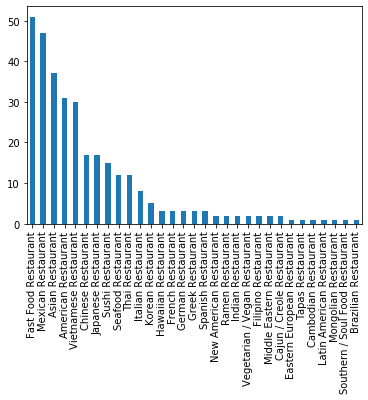

In [27]:
#Quick initial Visualization
tacfood['Venue Category'].value_counts().plot(kind='bar')

In [28]:
#Group restaurants by the Neighborhood they are located
tacfood.groupby('Neighborhood').count().head()

Neighborhood Latitude  \
Neighborhood                                                                
Fife                                                                   14   
Fircrest, University Pl, University Place                              11   
Fort Lewis, Ft Lewis, Joint Base Lewis Mcchord,...                      2   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...                      5   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...                     36   

                                                    Neighborhood Longitude  \
Neighborhood                                                                 
Fife                                                                    14   
Fircrest, University Pl, University Place                               11   
Fort Lewis, Ft Lewis, Joint Base Lewis Mcchord,...                       2   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...                       5   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...                      36   

                                                    Venue  Venue Latitude  \
Neighborhood                                                                
Fife                                                   14              14   
Fircrest, University Pl, University Place              11              11   
Fort Lewis, Ft Lewis, Joint Base Lewis Mcchord,...      2               2   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...      5               5   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...     36              36   

                                                    Venue Longitude  \
Neighborhood                                                          
Fife                                                             14   
Fircrest, University Pl, University Place                        11   
Fort Lewis, Ft Lewis, Joint Base Lewis Mcchord,...                2   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...                5   
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...               36   

                                                    Venue Category  
Neighborhood                                                        
Fife                                                            14  
Fircrest, University Pl, University Place                       11  
Fort Lewis, Ft Lewis, Joint Base Lewis Mcchord,...               2  
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...               5  
Joint Base Lewis Mcchord, Lewis Mcchord, Mcchor...              36

In [29]:
#Analyze the neighborhoods
#dummy code
tac_onehot= pd.get_dummies(tacfood[['Venue Category']],prefix="",prefix_sep="")

#Adds neighborhood back to dataframe
tac_onehot['Neighborhood']=tacfood['Neighborhood']

#Moves 'neighborhood' column
fixed_columns = [tac_onehot.columns[-1]] + list(tac_onehot.columns[:-1])
tac_onehot = tac_onehot[fixed_columns]

print(tac_onehot.shape)
tac_onehot.head()

(318, 32)


Neighborhood  American Restaurant  Asian Restaurant  Brazilian Restaurant  \
0       Tacoma1                    1                 0                     0   
1       Tacoma1                    0                 0                     0   
4       Tacoma1                    1                 0                     0   
5       Tacoma1                    0                 0                     0   
10      Tacoma1                    0                 1                     0   

    Cajun / Creole Restaurant  Cambodian Restaurant  Chinese Restaurant  \
0                           0                     0                   0   
1                           0                     0                   0   
4                           0                     0                   0   
5                           0                     0                   0   
10                          0                     0                   0   

    Eastern European Restaurant  Fast Food Restaurant  Filipino Restaurant  \
0                             0                     0                    0   
1                             0                     0                    0   
4                             0                     0                    0   
5                             0                     0                    0   
10                            0                     0                    0   

    ...  New American Restaurant  Ramen Restaurant  Seafood Restaurant  \
0   ...                        0                 0                   0   
1   ...                        0                 0                   0   
4   ...                        0                 0                   0   
5   ...                        0                 0                   0   
10  ...                        0                 0                   0   

    Southern / Soul Food Restaurant  Spanish Restaurant  Sushi Restaurant  \
0                                 0                   0                 0   
1                                 0                   0                 0   
4                                 0                   0                 0   
5                                 0                   0                 0   
10                                0                   0                 0   

    Tapas Restaurant  Thai Restaurant  Vegetarian / Vegan Restaurant  \
0                  0                0                              0   
1                  0                0                              0   
4                  0                0                              0   
5                  0                0                              0   
10                 0                0                              0   

    Vietnamese Restaurant  
0                       0  
1                       0  
4                       0  
5                       0  
10                      0  

[5 rows x 32 columns]

In [30]:
# Neighborhoods now grouped and average # of restaurants in the area by restaurant type presented
tacoma_grouped = tac_onehot.groupby('Neighborhood').mean().reset_index()
print(tacoma_grouped.shape)
tacoma_grouped.head()

(22, 32)


Neighborhood  American Restaurant  \
0                                               Fife             0.071429   
1          Fircrest, University Pl, University Place             0.090909   
2  Fort Lewis, Ft Lewis, Joint Base Lewis Mcchord...             0.000000   
3  Joint Base Lewis Mcchord, Lewis Mcchord, Mccho...             0.000000   
4  Joint Base Lewis Mcchord, Lewis Mcchord, Mccho...             0.083333   

   Asian Restaurant  Brazilian Restaurant  Cajun / Creole Restaurant  \
0          0.142857                   0.0                        0.0   
1          0.181818                   0.0                        0.0   
2          0.000000                   0.0                        0.0   
3          0.200000                   0.0                        0.0   
4          0.055556                   0.0                        0.0   

   Cambodian Restaurant  Chinese Restaurant  Eastern European Restaurant  \
0                   0.0            0.071429                     0.000000   
1                   0.0            0.000000                     0.000000   
2                   0.0            0.000000                     0.000000   
3                   0.0            0.000000                     0.000000   
4                   0.0            0.083333                     0.027778   

   Fast Food Restaurant  Filipino Restaurant  ...  New American Restaurant  \
0              0.285714             0.000000  ...                      0.0   
1              0.181818             0.000000  ...                      0.0   
2              0.000000             0.000000  ...                      0.0   
3              0.600000             0.000000  ...                      0.0   
4              0.194444             0.055556  ...                      0.0   

   Ramen Restaurant  Seafood Restaurant  Southern / Soul Food Restaurant  \
0               0.0            0.000000                              0.0   
1               0.0            0.000000                              0.0   
2               0.0            0.000000                              0.0   
3               0.0            0.000000                              0.0   
4               0.0            0.027778                              0.0   

   Spanish Restaurant  Sushi Restaurant  Tapas Restaurant  Thai Restaurant  \
0            0.000000          0.000000               0.0         0.071429   
1            0.000000          0.000000               0.0         0.000000   
2            0.000000          0.000000               0.0         0.000000   
3            0.000000          0.000000               0.0         0.000000   
4            0.027778          0.027778               0.0         0.000000   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                            0.0               0.142857  
1                            0.0               0.090909  
2                            0.0               0.000000  
3                            0.0               0.000000  
4                            0.0               0.055556  

[5 rows x 32 columns]

In [31]:
#Function to find most popular venues
def return_most_common_venues (row,num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [32]:
#Set to return 5 must common venues
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = tacoma_grouped['Neighborhood']

for ind in np.arange(tacoma_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tacoma_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()
print(neighborhoods_venues_sorted.shape)

(22, 6)


In [35]:
tac_onehot1=tac_onehot.drop(['Neighborhood'],axis=1)
X = tac_onehot1
X[0:5]

American Restaurant  Asian Restaurant  Brazilian Restaurant  \
0                     1                 0                     0   
1                     0                 0                     0   
4                     1                 0                     0   
5                     0                 0                     0   
10                    0                 1                     0   

    Cajun / Creole Restaurant  Cambodian Restaurant  Chinese Restaurant  \
0                           0                     0                   0   
1                           0                     0                   0   
4                           0                     0                   0   
5                           0                     0                   0   
10                          0                     0                   0   

    Eastern European Restaurant  Fast Food Restaurant  Filipino Restaurant  \
0                             0                     0                    0   
1                             0                     0                    0   
4                             0                     0                    0   
5                             0                     0                    0   
10                            0                     0                    0   

    French Restaurant  ...  New American Restaurant  Ramen Restaurant  \
0                   0  ...                        0                 0   
1                   0  ...                        0                 0   
4                   0  ...                        0                 0   
5                   1  ...                        0                 0   
10                  0  ...                        0                 0   

    Seafood Restaurant  Southern / Soul Food Restaurant  Spanish Restaurant  \
0                    0                                0                   0   
1                    0                                0                   0   
4                    0                                0                   0   
5                    0                                0                   0   
10                   0                                0                   0   

    Sushi Restaurant  Tapas Restaurant  Thai Restaurant  \
0                  0                 0                0   
1                  0                 0                0   
4                  0                 0                0   
5                  0                 0                0   
10                 0                 0                0   

    Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                               0                      0  
1                               0                      0  
4                               0                      0  
5                               0                      0  
10                              0                      0  

[5 rows x 31 columns]

In [36]:
y = tacfood['Neighborhood'].values
y[0:5]

array(['Tacoma1', 'Tacoma1', 'Tacoma1', 'Tacoma1', 'Tacoma1'],
      dtype=object)

In [37]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 3.04270677, -0.36286719, -0.0561656 , -0.07955573, -0.0561656 ,
        -0.23765186, -0.0561656 , -0.43704832, -0.07955573, -0.09759001,
        -0.09759001, -0.09759001, -0.09759001, -0.07955573, -0.16064387,
        -0.23765186, -0.12639003, -0.0561656 , -0.41645136, -0.07955573,
        -0.0561656 , -0.07955573, -0.07955573, -0.19802951, -0.0561656 ,
        -0.09759001, -0.22249708, -0.0561656 , -0.19802951, -0.07955573,
        -0.32274861],
       [-0.32865474, -0.36286719, -0.0561656 , -0.07955573, -0.0561656 ,
        -0.23765186, -0.0561656 , -0.43704832, -0.07955573, -0.09759001,
        -0.09759001, -0.09759001, -0.09759001, -0.07955573, -0.16064387,
        -0.23765186, -0.12639003, -0.0561656 ,  2.40124081, -0.07955573,
        -0.0561656 , -0.07955573, -0.07955573, -0.19802951, -0.0561656 ,
        -0.09759001, -0.22249708, -0.0561656 , -0.19802951, -0.07955573,
        -0.32274861],
       [ 3.04270677, -0.36286719, -0.0561656 , -0.07955573, -0.0561656 ,
       

In [39]:
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
X= preprocessing.StandardScaler().fit(X).transform(X)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (254, 31) (254,)
Test set: (64, 31) (64,)


[0.140625 0.0625   0.046875 0.046875 0.03125  0.09375  0.15625  0.109375
 0.171875 0.171875 0.15625  0.15625  0.171875 0.15625 ]
[0.04345429 0.03025768 0.02642139 0.02642139 0.02174908 0.03643507
 0.04538652 0.03901364 0.04715897 0.04715897 0.04538652 0.04538652
 0.04715897 0.04538652]


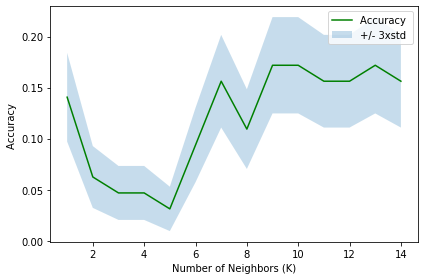

In [43]:
Ks = 15
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

print(mean_acc)
print(std_acc)

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.25)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [44]:
#should do above w neighborhood not restaurant category
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.171875 with k= 9


In [45]:
kclusters = 9

tacoma_grouped_clustering = tacoma_grouped.drop('Neighborhood', 1)

kmeans1 = KMeans(n_clusters=kclusters, random_state=0).fit(tacoma_grouped_clustering)

kmeans1.labels_[0:10]

array([7, 7, 2, 3, 0, 0, 7, 7, 6, 5], dtype=int32)

In [46]:
neighborhoods_venues_sorted.insert(0, 'ClusterLabels', kmeans1.labels_)

#merge tacoma_grouped with tacoma_data to add latitude/longitude for each neighborhood
tacoma_merged = tacfood.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

tacoma_merged.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0       Tacoma1                  47.26                 -122.44   
1       Tacoma1                  47.26                 -122.44   
4       Tacoma1                  47.26                 -122.44   
5       Tacoma1                  47.26                 -122.44   
10      Tacoma1                  47.26                 -122.44   

                              Venue  Venue Latitude  Venue Longitude  \
0                Over the Moon Cafe       47.257328      -122.441662   
1                       The Matador       47.256636      -122.439188   
4   McMenamins Elks Temple Main Pub       47.257967      -122.440578   
5                               Sel       47.261201      -122.444835   
10         indo Asian Street Eatery       47.264593      -122.449102   

         Venue Category  ClusterLabels 1st Most Common Venue  \
0   American Restaurant              6   American Restaurant   
1    Mexican Restaurant              6   American Restaurant   
4   American Restaurant              6   American Restaurant   
5     French Restaurant              6   American Restaurant   
10     Asian Restaurant              6   American Restaurant   

    2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
0   Vietnamese Restaurant      Sushi Restaurant       Thai Restaurant   
1   Vietnamese Restaurant      Sushi Restaurant       Thai Restaurant   
4   Vietnamese Restaurant      Sushi Restaurant       Thai Restaurant   
5   Vietnamese Restaurant      Sushi Restaurant       Thai Restaurant   
10  Vietnamese Restaurant      Sushi Restaurant       Thai Restaurant   

   5th Most Common Venue  
0     Mexican Restaurant  
1     Mexican Restaurant  
4     Mexican Restaurant  
5     Mexican Restaurant  
10    Mexican Restaurant

In [48]:
#Map the neighborhoods and the surrounding restaurants
tac_map = folium.Map(location=[latTac, longTac], zoom_start=10) # generate map centred around the Tacoma

near_venue = plugins.MarkerCluster().add_to(tac_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, name, in zip(tacoma_merged['Venue Latitude'], tacoma_merged['Venue Longitude'], 
                           tacoma_merged['Venue Category']):
    label = folium.Popup(str(name), parse_html=True)
    folium.Marker(
        [lat, lng],
         popup=label
    ).add_to(near_venue)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tacoma_merged['Neighborhood Latitude'], tacoma_merged['Neighborhood Longitude'], 
                                  tacoma_merged['Neighborhood'], tacoma_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tac_map)
       
tac_map

In [49]:
#Repeat for Seattle
seattle_venues = getNearbyVenues(seattlezip['cityname'],seattlezip['latitude'],seattlezip['longitude'])

Seattle1
Seattle2
Seattle3
Seattle4
Seattle5
Seattle6
Seattle7
Tukwila1
Seattle8
Bainbridge Is, Seattle
Seattle9
Seattle10
Seattle11
Seattle12
Seattle13
Seattle14
Seattle15
Seattle16
Seattle17
Seattle18
Seattle19
Seattle20
Shoreline1
Seattle21
Seattle22
Seattle23
Burien
Burien, Des Moines, Normandy Park, Seatac
Seattle24
Lake Forest Park, Lk Forest Pk, Shoreline
Seatac
Seattle25
Seattle26
Burien, Normandy Park
Burien, Seatac, Tukwila
Seattle27
Seattle28
Shoreline2
Tukwila2
Seatac, Tukwila
Des Moines, Normandy Park, Seatac
Seattle29


In [50]:
#See how many venues there are in Seattle
print(seattle_venues.shape)
seattle_venues.head()

(2420, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0     Seattle1                  47.61                 -122.33   
1     Seattle1                  47.61                 -122.33   
2     Seattle1                  47.61                 -122.33   
3     Seattle1                  47.61                 -122.33   
4     Seattle1                  47.61                 -122.33   

                             Venue  Venue Latitude  Venue Longitude  \
0  George's Sausage & Delicatessen       47.608527      -122.327014   
1                        MOD Pizza       47.609490      -122.332647   
2        Dough Zone Dumpling House       47.613386      -122.332231   
3                            Rumba       47.613701      -122.328504   
4               The Capital Grille       47.608115      -122.335077   

         Venue Category  
0        Sandwich Place  
1           Pizza Place  
2   Dumpling Restaurant  
3  Caribbean Restaurant  
4   American Restaurant

In [52]:
#Filter for just Venue Category of Restaurants
seafood = seattle_venues[seattle_venues['Venue Category'].str.contains('Restaurant')]
#Remove the non-descriptive category 'Restaurant'
seafood = seafood[seafood['Venue Category']!='Restaurant']
print ('There are {} unique restaurant categories in Tacoma'.format(len(seafood['Venue Category'].unique())))

There are 56 unique restaurant categories in Tacoma


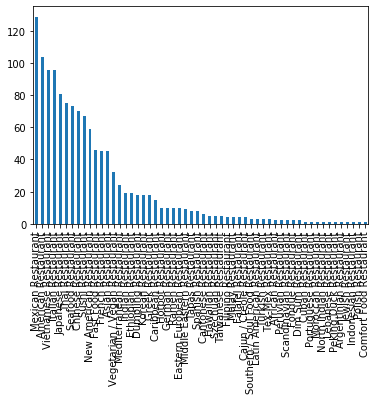

In [53]:
#Quick Visualization
seafood['Venue Category'].value_counts().plot(kind='bar')

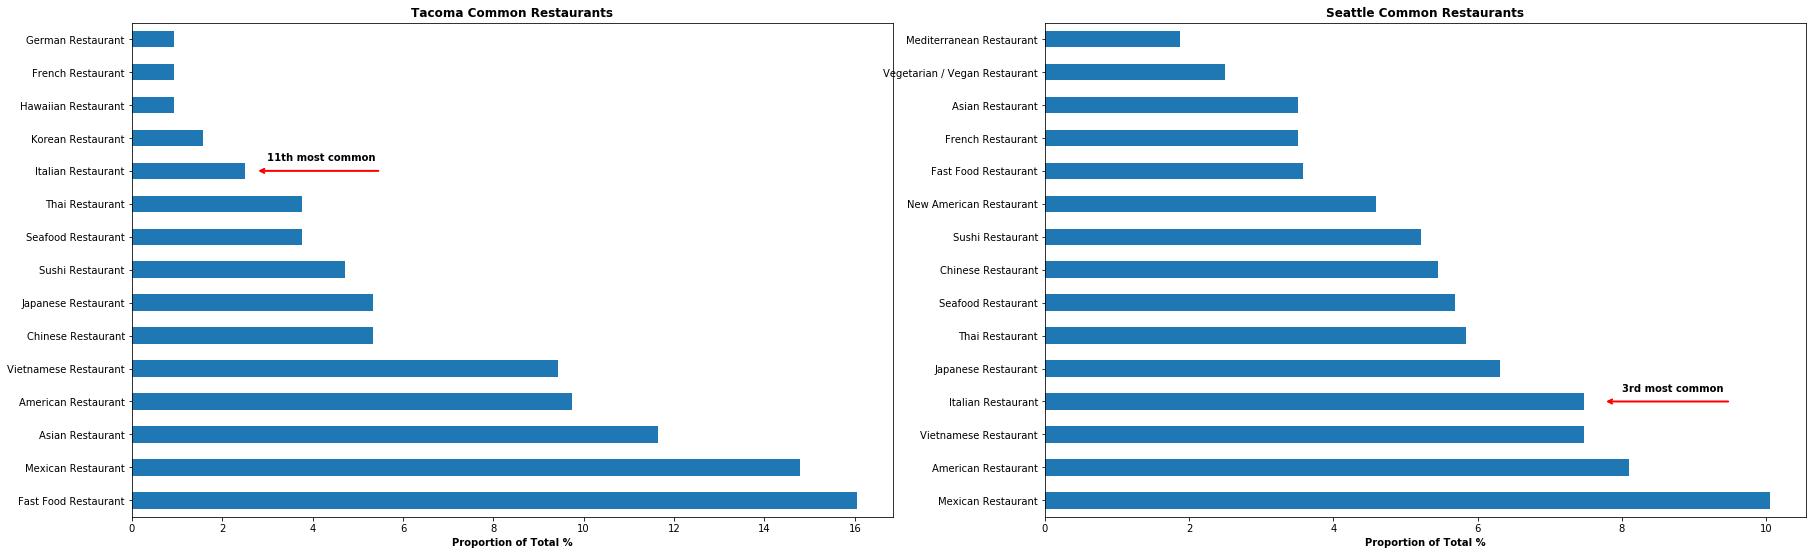

In [60]:
#Compare Tacoma and Seattle restaurants, point out category more popular in Seattle
fig = plt.figure() # create figure

ax0 = fig.add_subplot(221)   # add subplot 1 (3 rows, 1 column, first plot)
ax1 = fig.add_subplot(222) # add subplot 2 (3 rows, 1 column, second plot).

# Subplot 1: Tacoma
tacfood['Venue Category'].value_counts(normalize=True).mul(100).head(15).plot(
    kind='barh', figsize=(30,20), ax=ax0) # add to subplot 1
ax0.set_title('Tacoma Common Restaurants', fontweight='bold')
ax0.set_xlabel('Proportion of Total %', fontweight='bold')
ax0.annotate('',                      # s: str. will leave it blank for no text
        xy=(2.75, 10),             # place head of the arrow at point 
        xytext=(5.5, 10),         # place base of the arrow at point
        xycoords='data',         # will use the coordinate system of the object being annotated 
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2)
          )
ax0.annotate('11th most common', # text to display
        xy=(3, 10.25),             # Text starting point
        rotation=0,                # based on trial and error to match the arrow
        va='bottom',                # want the text to be vertically 'bottom' aligned
        ha='left', fontweight='bold', # want the text to be horizontally 'left' algned.
           )
# Subplot 2: Seattle
seafood['Venue Category'].value_counts(normalize=True).mul(100).head(15).plot(
    kind='barh', figsize=(30,20), ax=ax1) # add to subplot 1
ax1.set_title('Seattle Common Restaurants', fontweight='bold')
ax1.set_xlabel('Proportion of Total %', fontweight='bold')
ax1.annotate('',                      # s: str. will leave it blank for no text
        xy=(7.75, 3),             # place head of the arrow at point
        xytext=(9.5, 3),         # place base of the arrow at point
        xycoords='data',         # will use the coordinate system of the object being annotated 
        arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='red', lw=2)
          )
ax1.annotate('3rd most common',  # text to display
        xy=(8, 3.25),             # Text starting point
        rotation=0,                # based on trial and error to match the arrow
        va='bottom',                # want the text to be vertically 'bottom' aligned
        ha='left', fontweight='bold', # want the text to be horizontally 'left' algned.
           )
plt.show()

In [84]:
tacfood['Venue Category'].value_counts(normalize=True).mul(100).head(15)

Fast Food Restaurant     16.037736
Mexican Restaurant       14.779874
Asian Restaurant         11.635220
American Restaurant       9.748428
Vietnamese Restaurant     9.433962
Chinese Restaurant        5.345912
Japanese Restaurant       5.345912
Sushi Restaurant          4.716981
Seafood Restaurant        3.773585
Thai Restaurant           3.773585
Italian Restaurant        2.515723
Korean Restaurant         1.572327
Hawaiian Restaurant       0.943396
French Restaurant         0.943396
German Restaurant         0.943396
Name: Venue Category, dtype: float64

In [85]:
seafood['Venue Category'].value_counts(normalize=True).mul(100).head(15)

Mexican Restaurant               10.046729
American Restaurant               8.099688
Vietnamese Restaurant             7.476636
Italian Restaurant                7.476636
Japanese Restaurant               6.308411
Thai Restaurant                   5.841121
Seafood Restaurant                5.685358
Chinese Restaurant                5.451713
Sushi Restaurant                  5.218069
New American Restaurant           4.595016
Fast Food Restaurant              3.582555
French Restaurant                 3.504673
Asian Restaurant                  3.504673
Vegetarian / Vegan Restaurant     2.492212
Mediterranean Restaurant          1.869159
Name: Venue Category, dtype: float64

__Based on the above figures and data, we have initial answers for both of our questions.__
1. The most popular (non-fast food) restaurant style in Tacoma is a Mexican restaurant at 14.78% of all restaurants.
2. When compared to Seattle, Tacoma has a lower percentage of Italian restaurants. In Tacoma, Italian restaurants account for about 2.52% of the total, while in Seattle Italian restaurants account for 7.48%. Alternatively, the proportion of Italian restaurants in Seattle is 2.97x that in Tacoma.

In [61]:
#Group by areas in Seattle
seafood.groupby('Neighborhood').count().head()

Neighborhood Latitude  \
Neighborhood                                                       
Bainbridge Is, Seattle                                         7   
Burien                                                         5   
Burien, Des Moines, Normandy Park, Seatac                     27   
Burien, Normandy Park                                          6   
Burien, Seatac, Tukwila                                       12   

                                           Neighborhood Longitude  Venue  \
Neighborhood                                                               
Bainbridge Is, Seattle                                          7      7   
Burien                                                          5      5   
Burien, Des Moines, Normandy Park, Seatac                      27     27   
Burien, Normandy Park                                           6      6   
Burien, Seatac, Tukwila                                        12     12   

                                           Venue Latitude  Venue Longitude  \
Neighborhood                                                                 
Bainbridge Is, Seattle                                  7                7   
Burien                                                  5                5   
Burien, Des Moines, Normandy Park, Seatac              27               27   
Burien, Normandy Park                                   6                6   
Burien, Seatac, Tukwila                                12               12   

                                           Venue Category  
Neighborhood                                               
Bainbridge Is, Seattle                                  7  
Burien                                                  5  
Burien, Des Moines, Normandy Park, Seatac              27  
Burien, Normandy Park                                   6  
Burien, Seatac, Tukwila                                12

In [62]:
#Analyze the neighborhoods in Seattle
#dummy code
sea_onehot= pd.get_dummies(seafood[['Venue Category']],prefix="",prefix_sep="")

#Adds neighborhood back to dataframe
sea_onehot['Neighborhood']=seafood['Neighborhood']

#Moves 'neighborhood' column
fixed_columns = [sea_onehot.columns[-1]] + list(sea_onehot.columns[:-1])
sea_onehot = sea_onehot[fixed_columns]

print(sea_onehot.shape)
sea_onehot.head()

(1284, 57)


Neighborhood  African Restaurant  American Restaurant  \
2     Seattle1                   0                    0   
3     Seattle1                   0                    0   
4     Seattle1                   0                    1   
5     Seattle1                   0                    0   
6     Seattle1                   0                    0   

   Argentinian Restaurant  Asian Restaurant  Cajun / Creole Restaurant  \
2                       0                 0                          0   
3                       0                 0                          0   
4                       0                 0                          0   
5                       0                 0                          0   
6                       0                 0                          0   

   Cantonese Restaurant  Caribbean Restaurant  Chinese Restaurant  \
2                     0                     0                   0   
3                     0                     1                   0   
4                     0                     0                   0   
5                     0                     0                   0   
6                     0                     0                   0   

   Comfort Food Restaurant  ...  Spanish Restaurant  Sushi Restaurant  \
2                        0  ...                   0                 0   
3                        0  ...                   0                 0   
4                        0  ...                   0                 0   
5                        0  ...                   0                 0   
6                        0  ...                   0                 0   

   Szechuan Restaurant  Taiwanese Restaurant  Tapas Restaurant  \
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   
5                    0                     0                 0   
6                    0                     0                 0   

   Tex-Mex Restaurant  Thai Restaurant  Turkish Restaurant  \
2                   0                0                   0   
3                   0                0                   0   
4                   0                0                   0   
5                   0                0                   0   
6                   0                0                   0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
2                              0                      0  
3                              0                      0  
4                              0                      0  
5                              0                      0  
6                              0                      1  

[5 rows x 57 columns]

In [63]:
sea_grouped = sea_onehot.groupby('Neighborhood').mean().reset_index()
print(sea_grouped.shape)
sea_grouped.head()

(42, 57)


Neighborhood  African Restaurant  \
0                     Bainbridge Is, Seattle                 0.0   
1                                     Burien                 0.0   
2  Burien, Des Moines, Normandy Park, Seatac                 0.0   
3                      Burien, Normandy Park                 0.0   
4                    Burien, Seatac, Tukwila                 0.0   

   American Restaurant  Argentinian Restaurant  Asian Restaurant  \
0             0.000000                     0.0          0.000000   
1             0.000000                     0.0          0.000000   
2             0.111111                     0.0          0.037037   
3             0.166667                     0.0          0.166667   
4             0.000000                     0.0          0.000000   

   Cajun / Creole Restaurant  Cantonese Restaurant  Caribbean Restaurant  \
0                        0.0                   0.0                   0.0   
1                        0.0                   0.0                   0.0   
2                        0.0                   0.0                   0.0   
3                        0.0                   0.0                   0.0   
4                        0.0                   0.0                   0.0   

   Chinese Restaurant  Comfort Food Restaurant  ...  Spanish Restaurant  \
0            0.142857                      0.0  ...                 0.0   
1            0.000000                      0.0  ...                 0.0   
2            0.074074                      0.0  ...                 0.0   
3            0.000000                      0.0  ...                 0.0   
4            0.083333                      0.0  ...                 0.0   

   Sushi Restaurant  Szechuan Restaurant  Taiwanese Restaurant  \
0          0.000000                  0.0                   0.0   
1          0.000000                  0.0                   0.0   
2          0.074074                  0.0                   0.0   
3          0.000000                  0.0                   0.0   
4          0.000000                  0.0                   0.0   

   Tapas Restaurant  Tex-Mex Restaurant  Thai Restaurant  Turkish Restaurant  \
0               0.0            0.000000         0.000000                 0.0   
1               0.0            0.000000         0.000000                 0.0   
2               0.0            0.037037         0.037037                 0.0   
3               0.0            0.000000         0.166667                 0.0   
4               0.0            0.000000         0.000000                 0.0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
0                            0.0                    0.0  
1                            0.0                    0.2  
2                            0.0                    0.0  
3                            0.0                    0.0  
4                            0.0                    0.0  

[5 rows x 57 columns]

In [64]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
sea_venues_sorted = pd.DataFrame(columns=columns)
sea_venues_sorted['Neighborhood'] = sea_grouped['Neighborhood']

for ind in np.arange(sea_grouped.shape[0]):
    sea_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sea_grouped.iloc[ind, :], num_top_venues)

sea_venues_sorted.head()

Neighborhood 1st Most Common Venue  \
0                     Bainbridge Is, Seattle    Mexican Restaurant   
1                                     Burien    Mexican Restaurant   
2  Burien, Des Moines, Normandy Park, Seatac   Japanese Restaurant   
3                      Burien, Normandy Park    Mexican Restaurant   
4                    Burien, Seatac, Tukwila  Fast Food Restaurant   

  2nd Most Common Venue  3rd Most Common Venue     4th Most Common Venue  \
0  Fast Food Restaurant      Indian Restaurant  Mediterranean Restaurant   
1  Fast Food Restaurant  Vietnamese Restaurant       Japanese Restaurant   
2    Mexican Restaurant    American Restaurant          Sushi Restaurant   
3   American Restaurant        Thai Restaurant          Asian Restaurant   
4    Mexican Restaurant   Ethiopian Restaurant         Indian Restaurant   

   5th Most Common Venue  
0     Chinese Restaurant  
1  Indonesian Restaurant  
2   Fast Food Restaurant  
3    Japanese Restaurant  
4     Chinese Restaurant

In [68]:
sea_onehot1=sea_onehot.drop(['Neighborhood'],axis=1)
X1 = sea_onehot1
X1[0:5]

African Restaurant  American Restaurant  Argentinian Restaurant  \
2                   0                    0                       0   
3                   0                    0                       0   
4                   0                    1                       0   
5                   0                    0                       0   
6                   0                    0                       0   

   Asian Restaurant  Cajun / Creole Restaurant  Cantonese Restaurant  \
2                 0                          0                     0   
3                 0                          0                     0   
4                 0                          0                     0   
5                 0                          0                     0   
6                 0                          0                     0   

   Caribbean Restaurant  Chinese Restaurant  Comfort Food Restaurant  \
2                     0                   0                        0   
3                     1                   0                        0   
4                     0                   0                        0   
5                     0                   0                        0   
6                     0                   0                        0   

   Cuban Restaurant  ...  Spanish Restaurant  Sushi Restaurant  \
2                 0  ...                   0                 0   
3                 0  ...                   0                 0   
4                 0  ...                   0                 0   
5                 0  ...                   0                 0   
6                 0  ...                   0                 0   

   Szechuan Restaurant  Taiwanese Restaurant  Tapas Restaurant  \
2                    0                     0                 0   
3                    0                     0                 0   
4                    0                     0                 0   
5                    0                     0                 0   
6                    0                     0                 0   

   Tex-Mex Restaurant  Thai Restaurant  Turkish Restaurant  \
2                   0                0                   0   
3                   0                0                   0   
4                   0                0                   0   
5                   0                0                   0   
6                   0                0                   0   

   Vegetarian / Vegan Restaurant  Vietnamese Restaurant  
2                              0                      0  
3                              0                      0  
4                              0                      0  
5                              0                      0  
6                              0                      1  

[5 rows x 56 columns]

In [69]:
y1 = seafood['Neighborhood'].values
y1[0:5]

array(['Seattle1', 'Seattle1', 'Seattle1', 'Seattle1', 'Seattle1'],
      dtype=object)

In [70]:
X1= preprocessing.StandardScaler().fit(X1).transform(X1)
X1[0:5]

array([[-0.03949763, -0.29687639, -0.02791815, -0.19057705, -0.0559017 ,
        -0.06851887, -0.10872135, -0.24012627, -0.02791815, -0.02791815,
        -0.03949763,  8.38649708, -0.08859624, -0.12255514, -0.0559017 ,
        -0.19276074, -0.0559017 , -0.03949763, -0.19057705, -0.08859624,
        -0.1192393 , -0.06252443, -0.08859624, -0.12255514, -0.02791815,
        -0.28426762, -0.25948347, -0.02791815, -0.1192393 , -0.04839339,
        -0.02791815, -0.0559017 , -0.13801311, -0.33419801, -0.08401681,
        -0.02791815, -0.21946131, -0.02791815, -0.02791815, -0.03949763,
        -0.02791815, -0.02791815, -0.08859624, -0.03949763, -0.2455214 ,
        -0.04839339, -0.07918076, -0.23463463, -0.06252443, -0.06252443,
        -0.07918076, -0.04839339, -0.24906774, -0.04839339, -0.15987215,
        -0.28426762],
       [-0.03949763, -0.29687639, -0.02791815, -0.19057705, -0.0559017 ,
        -0.06851887,  9.19782583, -0.24012627, -0.02791815, -0.02791815,
        -0.03949763, -0.11923

In [71]:
X_train1, X_test1, y_train1, y_test1 = train_test_split( X1, y1, test_size=0.2, random_state=4)
X1= preprocessing.StandardScaler().fit(X1).transform(X1)
print ('Train set:', X_train1.shape,  y_train1.shape)
print ('Test set:', X_test1.shape,  y_test1.shape)

Train set: (1027, 56) (1027,)
Test set: (257, 56) (257,)


[0.04280156 0.05058366 0.04280156 0.03891051 0.04669261 0.04280156
 0.06614786 0.07003891 0.06225681 0.03891051 0.05058366 0.05836576
 0.06614786 0.06225681 0.05836576 0.06614786 0.05058366 0.04669261
 0.04280156]
[0.01262595 0.01366995 0.01262595 0.01206282 0.01316055 0.01262595
 0.01550352 0.01591972 0.01507193 0.01206282 0.01366995 0.01462358
 0.01550352 0.01507193 0.01462358 0.01550352 0.01366995 0.01316055
 0.01262595]


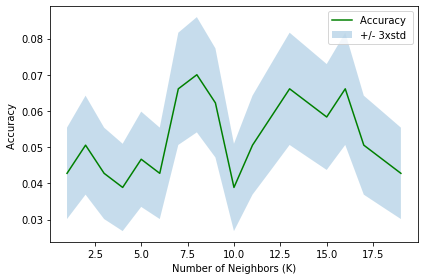

In [73]:
Ks = 20
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train1,y_train1)
    yhat1=neigh.predict(X_test1)
    mean_acc[n-1] = metrics.accuracy_score(y_test1, yhat1)

    
    std_acc[n-1]=np.std(yhat1==y_test1)/np.sqrt(yhat1.shape[0])

print(mean_acc)
print(std_acc)

plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.25)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Number of Neighbors (K)')
plt.tight_layout()
plt.show()

In [74]:
#should do above w neighborhood not restaurant category
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

The best accuracy was with 0.07003891050583658 with k= 8


In [75]:
kclusters = 8

sea_grouped_clustering = sea_grouped.drop('Neighborhood', 1)

kmeans2 = KMeans(n_clusters=kclusters, random_state=0).fit(sea_grouped_clustering)

kmeans2.labels_[0:10]

array([6, 5, 0, 0, 6, 5, 7, 4, 4, 1], dtype=int32)

In [76]:
sea_venues_sorted.insert(0, 'ClusterLabels', kmeans2.labels_)

#merge seattle grouped with seafood to add latitude/longitude for each neighborhood
sea_merged = seafood.join(sea_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

sea_merged.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
2     Seattle1                  47.61                 -122.33   
3     Seattle1                  47.61                 -122.33   
4     Seattle1                  47.61                 -122.33   
5     Seattle1                  47.61                 -122.33   
6     Seattle1                  47.61                 -122.33   

                         Venue  Venue Latitude  Venue Longitude  \
2    Dough Zone Dumpling House       47.613386      -122.332231   
3                        Rumba       47.613701      -122.328504   
4           The Capital Grille       47.608115      -122.335077   
5  Din Tai Fung Dumpling House       47.612671      -122.335073   
6                    Stateside       47.614075      -122.327354   

          Venue Category  ClusterLabels    1st Most Common Venue  \
2    Dumpling Restaurant              1  New American Restaurant   
3   Caribbean Restaurant              1  New American Restaurant   
4    American Restaurant              1  New American Restaurant   
5    Dumpling Restaurant              1  New American Restaurant   
6  Vietnamese Restaurant              1  New American Restaurant   

  2nd Most Common Venue 3rd Most Common Venue 4th Most Common Venue  \
2    Italian Restaurant    Seafood Restaurant   American Restaurant   
3    Italian Restaurant    Seafood Restaurant   American Restaurant   
4    Italian Restaurant    Seafood Restaurant   American Restaurant   
5    Italian Restaurant    Seafood Restaurant   American Restaurant   
6    Italian Restaurant    Seafood Restaurant   American Restaurant   

  5th Most Common Venue  
2     French Restaurant  
3     French Restaurant  
4     French Restaurant  
5     French Restaurant  
6     French Restaurant

In [83]:
sea_map = folium.Map(location=[latSea, longSea], zoom_start=10) # generate map centred around the Seattle

near_venue = plugins.MarkerCluster().add_to(sea_map)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, name, in zip(sea_merged['Venue Latitude'], sea_merged['Venue Longitude'], 
                           sea_merged['Venue Category']):
    label = folium.Popup(str(name), parse_html=True)
    folium.Marker(
        [lat, lng],
         popup=label,
    ).add_to(near_venue)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sea_merged['Neighborhood Latitude'], sea_merged['Neighborhood Longitude'], 
                                  sea_merged['Neighborhood'], sea_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(sea_map)
       
sea_map

In [87]:
#Fast food
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 0, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude               Venue Category  \
133                  47.26      -122.518331         Fast Food Restaurant   
134                  47.26      -122.513761           Italian Restaurant   
135                  47.26      -122.506583         Fast Food Restaurant   
144                  47.26      -122.514623             Sushi Restaurant   
146                  47.26      -122.490174             Sushi Restaurant   
..                     ...              ...                          ...   
617                  47.16      -122.483675        Vietnamese Restaurant   
619                  47.16      -122.518591           Mexican Restaurant   
620                  47.16      -122.518485         Fast Food Restaurant   
622                  47.16      -122.517228  Eastern European Restaurant   
624                  47.16      -122.515886         Fast Food Restaurant   

     ClusterLabels 1st Most Common Venue 2nd Most Common Venue  \
133              0  Fast Food Restaurant    Chinese Restaurant   
134              0  Fast Food Restaurant    Chinese Restaurant   
135              0  Fast Food Restaurant    Chinese Restaurant   
144              0  Fast Food Restaurant    Chinese Restaurant   
146              0  Fast Food Restaurant    Chinese Restaurant   
..             ...                   ...                   ...   
617              0    Mexican Restaurant  Fast Food Restaurant   
619              0    Mexican Restaurant  Fast Food Restaurant   
620              0    Mexican Restaurant  Fast Food Restaurant   
622              0    Mexican Restaurant  Fast Food Restaurant   
624              0    Mexican Restaurant  Fast Food Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
133      Sushi Restaurant      Asian Restaurant    Italian Restaurant  
134      Sushi Restaurant      Asian Restaurant    Italian Restaurant  
135      Sushi Restaurant      Asian Restaurant    Italian Restaurant  
144      Sushi Restaurant      Asian Restaurant    Italian Restaurant  
146      Sushi Restaurant      Asian Restaurant    Italian Restaurant  
..                    ...                   ...                   ...  
617   American Restaurant    Chinese Restaurant      Asian Restaurant  
619   American Restaurant    Chinese Restaurant      Asian Restaurant  
620   American Restaurant    Chinese Restaurant      Asian Restaurant  
622   American Restaurant    Chinese Restaurant      Asian Restaurant  
624   American Restaurant    Chinese Restaurant      Asian Restaurant  

[100 rows x 9 columns]

In [88]:
#Asian and Mexican
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 1, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude             Venue Category  \
314                  47.22      -122.443057      Vietnamese Restaurant   
316                  47.22      -122.441119         Mexican Restaurant   
317                  47.22      -122.442328      Vietnamese Restaurant   
319                  47.22      -122.434412         Mexican Restaurant   
321                  47.22      -122.434650      Vietnamese Restaurant   
322                  47.22      -122.440459         Mexican Restaurant   
323                  47.22      -122.431268        American Restaurant   
324                  47.22      -122.420471         Mexican Restaurant   
327                  47.22      -122.434218         Mexican Restaurant   
331                  47.22      -122.442334      Vietnamese Restaurant   
332                  47.22      -122.441160         Chinese Restaurant   
333                  47.22      -122.442938      Vietnamese Restaurant   
334                  47.22      -122.441119         Chinese Restaurant   
335                  47.22      -122.441119      Vietnamese Restaurant   
336                  47.22      -122.442539      Vietnamese Restaurant   
337                  47.22      -122.442571      Vietnamese Restaurant   
338                  47.22      -122.449782           Sushi Restaurant   
339                  47.22      -122.440333  Cajun / Creole Restaurant   
340                  47.22      -122.434670           Sushi Restaurant   
341                  47.22      -122.439623         Seafood Restaurant   
343                  47.22      -122.431744        Japanese Restaurant   
345                  47.22      -122.451210           Asian Restaurant   
346                  47.22      -122.433644       Fast Food Restaurant   
347                  47.22      -122.420660           Asian Restaurant   
411                  47.14      -122.437723         Mexican Restaurant   
412                  47.14      -122.436939           Sushi Restaurant   
413                  47.14      -122.439212         Italian Restaurant   
414                  47.14      -122.434274         Mexican Restaurant   
423                  47.14      -122.434915           Asian Restaurant   
427                  47.14      -122.434891      Vietnamese Restaurant   
429                  47.14      -122.438761        Japanese Restaurant   
432                  47.14      -122.433750        Japanese Restaurant   

     ClusterLabels  1st Most Common Venue 2nd Most Common Venue  \
314              1  Vietnamese Restaurant    Mexican Restaurant   
316              1  Vietnamese Restaurant    Mexican Restaurant   
317              1  Vietnamese Restaurant    Mexican Restaurant   
319              1  Vietnamese Restaurant    Mexican Restaurant   
321              1  Vietnamese Restaurant    Mexican Restaurant   
322              1  Vietnamese Restaurant    Mexican Restaurant   
323              1  Vietnamese Restaurant    Mexican Restaurant   
324              1  Vietnamese Restaurant    Mexican Restaurant   
327              1  Vietnamese Restaurant    Mexican Restaurant   
331              1  Vietnamese Restaurant    Mexican Restaurant   
332              1  Vietnamese Restaurant    Mexican Restaurant   
333              1  Vietnamese Restaurant    Mexican Restaurant   
334              1  Vietnamese Restaurant    Mexican Restaurant   
335              1  Vietnamese Restaurant    Mexican Restaurant   
336              1  Vietnamese Restaurant    Mexican Restaurant   
337              1  Vietnamese Restaurant    Mexican Restaurant   
338              1  Vietnamese Restaurant    Mexican Restaurant   
339              1  Vietnamese Restaurant    Mexican Restaurant   
340              1  Vietnamese Restaurant    Mexican Restaurant   
341              1  Vietnamese Restaurant    Mexican Restaurant   
343              1  Vietnamese Restaurant    Mexican Restaurant   
345              1  Vietnamese Restaurant    Mexican Restaurant   
346              1  V

In [89]:
#Mexican
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 2, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude      Venue Category  \
394                  47.11      -122.586184  Mexican Restaurant   
399                  47.11      -122.585964  Mexican Restaurant   

     ClusterLabels 1st Most Common Venue  2nd Most Common Venue  \
394              2    Mexican Restaurant  Vietnamese Restaurant   
399              2    Mexican Restaurant  Vietnamese Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
394    Italian Restaurant      Asian Restaurant  Brazilian Restaurant  
399    Italian Restaurant      Asian Restaurant  Brazilian Restaurant

In [90]:
#Fast Food
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 3, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  \
404                  47.12      -122.493440  Fast Food Restaurant   
405                  47.12      -122.495989  Fast Food Restaurant   
407                  47.12      -122.493228  Fast Food Restaurant   
408                  47.12      -122.508000    Mexican Restaurant   
410                  47.12      -122.495657      Asian Restaurant   

     ClusterLabels 1st Most Common Venue 2nd Most Common Venue  \
404              3  Fast Food Restaurant      Asian Restaurant   
405              3  Fast Food Restaurant      Asian Restaurant   
407              3  Fast Food Restaurant      Asian Restaurant   
408              3  Fast Food Restaurant      Asian Restaurant   
410              3  Fast Food Restaurant      Asian Restaurant   

    3rd Most Common Venue  4th Most Common Venue 5th Most Common Venue  
404    Mexican Restaurant  Vietnamese Restaurant    Italian Restaurant  
405    Mexican Restaurant  Vietnamese Restaurant    Italian Restaurant  
407    Mexican Restaurant  Vietnamese Restaurant    Italian Restaurant  
408    Mexican Restaurant  Vietnamese Restaurant    Italian Restaurant  
410    Mexican Restaurant  Vietnamese Restaurant    Italian Restaurant

In [91]:
#Asian & Latin
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 4, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude             Venue Category  \
551                  47.15      -122.559160           Asian Restaurant   
552                  47.15      -122.558928  Latin American Restaurant   

     ClusterLabels 1st Most Common Venue      2nd Most Common Venue  \
551              4      Asian Restaurant  Latin American Restaurant   
552              4      Asian Restaurant  Latin American Restaurant   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
551  Vietnamese Restaurant    Italian Restaurant  Brazilian Restaurant  
552  Vietnamese Restaurant    Italian Restaurant  Brazilian Restaurant

In [92]:
#Vietnamese
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 5, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude         Venue Category  \
525                   47.2       -122.54430    American Restaurant   
526                   47.2       -122.53949  Vietnamese Restaurant   

     ClusterLabels  1st Most Common Venue 2nd Most Common Venue  \
525              5  Vietnamese Restaurant   American Restaurant   
526              5  Vietnamese Restaurant   American Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
525       Thai Restaurant     Indian Restaurant      Asian Restaurant  
526       Thai Restaurant     Indian Restaurant      Asian Restaurant

In [93]:
#American and Mexican
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 6, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude       Venue Category  \
0                    47.26      -122.441662  American Restaurant   
1                    47.26      -122.439188   Mexican Restaurant   
4                    47.26      -122.440578  American Restaurant   
5                    47.26      -122.444835    French Restaurant   
10                   47.26      -122.449102     Asian Restaurant   
..                     ...              ...                  ...   
306                  47.20      -122.478873   Mexican Restaurant   
307                  47.20      -122.483840   Mexican Restaurant   
310                  47.20      -122.463566  American Restaurant   
311                  47.20      -122.483770   Mexican Restaurant   
313                  47.20      -122.460781  American Restaurant   

     ClusterLabels 1st Most Common Venue  2nd Most Common Venue  \
0                6   American Restaurant  Vietnamese Restaurant   
1                6   American Restaurant  Vietnamese Restaurant   
4                6   American Restaurant  Vietnamese Restaurant   
5                6   American Restaurant  Vietnamese Restaurant   
10               6   American Restaurant  Vietnamese Restaurant   
..             ...                   ...                    ...   
306              6    Mexican Restaurant    American Restaurant   
307              6    Mexican Restaurant    American Restaurant   
310              6    Mexican Restaurant    American Restaurant   
311              6    Mexican Restaurant    American Restaurant   
313              6    Mexican Restaurant    American Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
0        Sushi Restaurant       Thai Restaurant    Mexican Restaurant  
1        Sushi Restaurant       Thai Restaurant    Mexican Restaurant  
4        Sushi Restaurant       Thai Restaurant    Mexican Restaurant  
5        Sushi Restaurant       Thai Restaurant    Mexican Restaurant  
10       Sushi Restaurant       Thai Restaurant    Mexican Restaurant  
..                    ...                   ...                   ...  
306      Asian Restaurant    Italian Restaurant  Brazilian Restaurant  
307      Asian Restaurant    Italian Restaurant  Brazilian Restaurant  
310      Asian Restaurant    Italian Restaurant  Brazilian Restaurant  
311      Asian Restaurant    Italian Restaurant  Brazilian Restaurant  
313      Asian Restaurant    Italian Restaurant  Brazilian Restaurant  

[67 rows x 9 columns]

In [94]:
#Fast food and Asian
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 7, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude        Venue Category  \
97                   47.20      -122.413147    Mexican Restaurant   
98                   47.20      -122.409900  Fast Food Restaurant   
100                  47.20      -122.410005  Fast Food Restaurant   
103                  47.20      -122.409064  Fast Food Restaurant   
104                  47.20      -122.406591       Thai Restaurant   
..                     ...              ...                   ...   
541                  47.12      -122.555523      Asian Restaurant   
542                  47.12      -122.555847    Chinese Restaurant   
543                  47.12      -122.549201      Asian Restaurant   
544                  47.12      -122.555382  Fast Food Restaurant   
548                  47.12      -122.551303  Fast Food Restaurant   

     ClusterLabels 1st Most Common Venue 2nd Most Common Venue  \
97               7  Fast Food Restaurant   American Restaurant   
98               7  Fast Food Restaurant   American Restaurant   
100              7  Fast Food Restaurant   American Restaurant   
103              7  Fast Food Restaurant   American Restaurant   
104              7  Fast Food Restaurant   American Restaurant   
..             ...                   ...                   ...   
541              7  Fast Food Restaurant      Asian Restaurant   
542              7  Fast Food Restaurant      Asian Restaurant   
543              7  Fast Food Restaurant      Asian Restaurant   
544              7  Fast Food Restaurant      Asian Restaurant   
548              7  Fast Food Restaurant      Asian Restaurant   

     3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
97         Thai Restaurant      Asian Restaurant  Cambodian Restaurant  
98         Thai Restaurant      Asian Restaurant  Cambodian Restaurant  
100        Thai Restaurant      Asian Restaurant  Cambodian Restaurant  
103        Thai Restaurant      Asian Restaurant  Cambodian Restaurant  
104        Thai Restaurant      Asian Restaurant  Cambodian Restaurant  
..                     ...                   ...                   ...  
541  Vietnamese Restaurant    Mexican Restaurant    Chinese Restaurant  
542  Vietnamese Restaurant    Mexican Restaurant    Chinese Restaurant  
543  Vietnamese Restaurant    Mexican Restaurant    Chinese Restaurant  
544  Vietnamese Restaurant    Mexican Restaurant    Chinese Restaurant  
548  Vietnamese Restaurant    Mexican Restaurant    Chinese Restaurant  

[106 rows x 9 columns]

In [95]:
#Asian Foods
tacoma_merged.loc[tacoma_merged['ClusterLabels'] == 8, tacoma_merged.columns[[1] + list(range(5, tacoma_merged.shape[1]))]]

Neighborhood Latitude  Venue Longitude         Venue Category  \
355                  47.28      -122.362543  Vietnamese Restaurant   
356                  47.28      -122.361619     Chinese Restaurant   

     ClusterLabels  1st Most Common Venue 2nd Most Common Venue  \
355              8  Vietnamese Restaurant    Chinese Restaurant   
356              8  Vietnamese Restaurant    Chinese Restaurant   

    3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  
355    Italian Restaurant      Asian Restaurant  Brazilian Restaurant  
356    Italian Restaurant      Asian Restaurant  Brazilian Restaurant

In [104]:
#Map the neighborhoods and the location
tacoma_mfood = tacoma_merged[tacoma_merged['Venue Category']=='Mexican Restaurant']
tac_map2 = folium.Map(location=[latTac, longTac], zoom_start=10) # generate map centred around the Tacoma

near_venue = plugins.MarkerCluster().add_to(tac_map2)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, name, in zip(tacoma_mfood['Venue Latitude'], tacoma_mfood['Venue Longitude'], 
                           tacoma_mfood['Venue']):
    label = folium.Popup(str(name), parse_html=True)
    folium.Marker(
        [lat, lng],
         popup=label
    ).add_to(near_venue)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tacoma_merged['Neighborhood Latitude'], tacoma_merged['Neighborhood Longitude'], 
                                  tacoma_merged['Neighborhood'], tacoma_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tac_map2)
       
tac_map2

In [224]:
#Highlight Mexican Restaurants in Area
tac_mex = folium.Map(location=[latTac, longTac], zoom_start=10) # generate map centered around the Tacoma

near_venue = plugins.MarkerCluster().add_to(tac_mex)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, name, venue in zip(tacoma_merged['Venue Latitude'], tacoma_merged['Venue Longitude'], 
                           tacoma_merged['Venue'], tacoma_merged['Venue Category']):
    label = folium.Popup(str(name), parse_html=True)
    if venue == 'Mexican Restaurant':
        icon_filter = folium.Icon(color='red',icon_color='#FFFF00')
        folium.Marker([lat, lng],popup=label,icon=icon_filter).add_to(near_venue)
              
    else:
        icon_filter = folium.Icon(color='gray')
        folium.Marker([lat, lng],popup=label,icon=icon_filter).add_to(near_venue)  
    

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tacoma_merged['Neighborhood Latitude'], tacoma_merged['Neighborhood Longitude'], 
                                  tacoma_merged['Neighborhood'], tacoma_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tac_mex)
       
tac_mex

In [247]:
#Get only locations where Mexican Restaurant is Not Most Common (know where not to put it)
#If an owner wanted to find locations where Mexican food was not common at all compared to other restaurants
tac_mfood = tacoma_merged[tacoma_merged['1st Most Common Venue']!= 'Mexican Restaurant']
tac_mfood = tac_mfood[tac_mfood['2nd Most Common Venue']!= 'Mexican Restaurant']
tac_mfood = tac_mfood[tac_mfood['3rd Most Common Venue']!= 'Mexican Restaurant']
tac_mfood = tac_mfood[tac_mfood['4th Most Common Venue']!= 'Mexican Restaurant']
tac_mfood = tac_mfood[tac_mfood['5th Most Common Venue']!= 'Mexican Restaurant']
tac_mfood.shape

(106, 13)

In [254]:
#Figure out where Mexican food is not popular even if there is a restaurant nearby
for venue,name,cluster in zip(tac_mfood['Venue Category'],tac_mfood['Venue'],tac_mfood['ClusterLabels']):
    if venue=='Mexican Restaurant':
        print('This Mexican restaurant ({}) is located in cluster {}.'.format(name,cluster))

This Mexican restaurant (Tacos Guaymas) is located in cluster 7.
This Mexican restaurant (El Toro) is located in cluster 0.
This Mexican restaurant (Taco Del Mar) is located in cluster 0.
This Mexican restaurant (Taqueria El Rinconsito) is located in cluster 7.
This Mexican restaurant (Taquiera Tres Hermanos) is located in cluster 7.
This Mexican restaurant (Taqueria El Sabor) is located in cluster 7.


As a new restaurant owner, it would not be wise to open a Mexican restaurant in cluster 7 (near universities) because Mexican food (especially taquieras) is not popular even though there are already restaurants. 
In terms of a happy medium between amount of restaurants and distance to the nearest Mexican restaurant, it seems like cluster 6 (especially the Ruston area) may be ideal. There is a shopping area with ample parking as well as condominiums and apartments nearby. Further, the other restaurants represent American Food, Pizza, Japanese Food, and Seafood. Therefore there would be no direct competition in the area.

In [253]:
#Find the Italian Restaurants
for lat,lng,name,venue,cluster in zip(tacoma_merged['Venue Latitude'], tacoma_merged['Venue Longitude'], 
                           tacoma_merged['Venue'], tacoma_merged['Venue Category'],tacoma_merged['ClusterLabels']):
    if venue=='Italian Restaurant':
        print('This Italian restaurant ({}) is located in cluster {} at {},{}.'.format(name,cluster,lat,lng))

This Italian restaurant (The Old Spaghetti Factory) is located in cluster 6 at 47.251631,-122.438421.
This Italian restaurant (Joeseppi's) is located in cluster 0 at 47.26794082914178,-122.51376118987518.
This Italian restaurant (Round Table Clubhouse) is located in cluster 0 at 47.2714,-122.515289.
This Italian restaurant (Macaluso’s Italian Restaurant) is located in cluster 6 at 47.298197,-122.515545.
This Italian restaurant (Olive Garden) is located in cluster 6 at 47.19345039810585,-122.461536753527.
This Italian restaurant (Marzano's) is located in cluster 1 at 47.14605825492612,-122.43921242276525.
This Italian restaurant (Marzano's) is located in cluster 7 at 47.14605825492612,-122.43921242276525.
This Italian restaurant (Grassi's Ristorante) is located in cluster 7 at 47.23408951251858,-122.53667432809299.


In [255]:
#Highlight Italian Restaurants in Area because there are so few
tac_ital = folium.Map(location=[latTac, longTac], zoom_start=10) # generate map centered around the Tacoma

near_venue = plugins.MarkerCluster().add_to(tac_ital)

# loop through the dataframe and add each data point to the mark cluster
for lat, lng, name, venue in zip(tacoma_merged['Venue Latitude'], tacoma_merged['Venue Longitude'], 
                           tacoma_merged['Venue'], tacoma_merged['Venue Category']):
    label = folium.Popup(str(name), parse_html=True)
    if venue == 'Italian Restaurant':
        icon_filter = folium.Icon(color='green',icon_color='#FFFF00')
        folium.Marker([lat, lng],popup=label,icon=icon_filter).add_to(near_venue)
              
#     else:
#         icon_filter = folium.Icon(color='gray')
#         folium.Marker([lat, lng],popup=label,icon=icon_filter).add_to(near_venue)  
    

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tacoma_merged['Neighborhood Latitude'], tacoma_merged['Neighborhood Longitude'], 
                                  tacoma_merged['Neighborhood'], tacoma_merged['ClusterLabels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(tac_ital)
       
tac_ital

An owner of an Italian restaurant has many options in the Tacoma (and surrounding) area. One thing to note as an owner, the Italian restaurants seem to be located around the outskirts of Tacoma. In order to capitalize on a large amount of customers without nearby access to Italian food, an owner could search for a location between 6th avenue (near Cluster 5) and Ruston Way (Cluster 6). There seems to be an overall lack of restaurants that may benefit from a new spot.